# DQN

In [1]:
import torch
import random
import numpy as np
from collections import deque
from game import SnakeGameAI, Direction, Point
import pygame
import os

import math, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [3]:
def state(game):
    head = game.snake[0]
    west = Point(head.x - 20, head.y)
    east = Point(head.x + 20, head.y)
    north = Point(head.x, head.y - 20)
    south = Point(head.x, head.y + 20)

    left = game.direction == Direction.LEFT
    right = game.direction == Direction.RIGHT
    up = game.direction == Direction.UP
    down = game.direction == Direction.DOWN
    #print(game.snake)
    #print(left, right, up, down)
    
    state = [
        # Detect collision when moving straight
        (right and game.is_collision(east)) or 
        (left and game.is_collision(west)) or 
        (up and game.is_collision(north)) or 
        (down and game.is_collision(south)),

        # Detect collision when moving right
        (up and game.is_collision(east)) or 
        (down and game.is_collision(west)) or 
        (left and game.is_collision(north)) or 
        (right and game.is_collision(south)),

        # Detect collision when moving left
        (down and game.is_collision(east)) or 
        (up and game.is_collision(west)) or 
        (right and game.is_collision(north)) or 
        (left and game.is_collision(south)),

        # Move direction
        left, right, up, down,

        # Food location 
        game.food.x < game.head.x,  # food left
        game.food.x > game.head.x,  # food right
        game.food.y < game.head.y,  # food up
        game.food.y > game.head.y  # food down
        ]
    #print(state)
    return np.array(state, dtype=int)

In [4]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # popleft()

    def push(self, state, next_state, action, reward, done):
        self.memory.append((state, next_state, action, reward, done)) # popleft if MAX_MEMORY is reached

    def sample(self, batch_size):
        state, next_state, action, reward, done = zip(*random.sample(self.memory, batch_size))
        return state, next_state, action, reward, done
    
    def __len__(self):
        return len(self.memory)
    

In [5]:
def action_array(action, num_actions):
    if (action < num_actions):
        move = np.zeros(num_actions).astype(np.int)
        move[action] = 1
        #move = move.tolist()
        return move.tolist()
    else:
        print("exceed number of actions\n")
        return

In [6]:
def Loss(model, criterion, optimizer, gamma, state_i, state_i_new, move, reward, done):
    state = torch.tensor(state_i, dtype=torch.float)
    next_state = torch.tensor(state_i_new, dtype=torch.float)
    action = torch.tensor(move, dtype=torch.long)
    r = torch.tensor(reward, dtype=torch.float)
    #done = torch.FloatTensor(done)
    # (n, x)
    
    if len(state.shape) == 1:
        # (1, x)
        state = torch.unsqueeze(state, 0)
        next_state = torch.unsqueeze(next_state, 0)
        action = torch.unsqueeze(action, 0)
        r = torch.unsqueeze(r, 0)
        done = (done, )

    # 1: predicted Q values with current state
    Q_i = model(state.to(device))

    target_Q = Q_i.clone()
    for idx in range(len(done)):
        Q_new = r[idx]
        if not done[idx]:
            Q_new = r[idx].to(device) + gamma * torch.max(model(next_state[idx].to(device)))

        target_Q[idx][torch.argmax(action[idx]).item()] = Q_new

    # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
    # pred.clone()
    # preds[argmax(action)] = Q_new
    optimizer.zero_grad()
    loss = criterion(Q_i, target_Q) #!!
    loss.backward()

    optimizer.step()

    return loss

In [7]:
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training')
    plt.xlabel('Number of Episode')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

In [8]:
def save(model, file_name='Project.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)

    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(), file_name)

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.l = [256,128,64]
        self.classifier = nn.Sequential(
            nn.Linear(input_size, self.l[0]),
            #nn.BatchNorm1d(self.l[0]),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(self.l[0], self.l[1]),
            #nn.BatchNorm1d(self.l[1]),
            nn.ReLU(),
            nn.Linear(self.l[1], self.l[2]),
            #nn.BatchNorm1d(self.l[2]),
            nn.ReLU(),
            nn.Linear(self.l[2], output_size)
        )

    def forward(self, x):
        x = self.classifier(x)
        
        return x

class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [9]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        #x = self.classifier(x)
        return x

    def save(self, file_name='agentPP.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


In [10]:
channels_input = 11
num_actions = 3
model = DQN(channels_input, num_actions).to(device) # (180, 120, 3) , (6)

lr = 5e-5
    
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()

replay_buffer = ReplayBuffer(50000)

# Frame:
total_eps = 1000
batch_size = 1000
gamma = 0.99

# start:
#game = SnakeGameAI()

<Figure size 432x288 with 0 Axes>

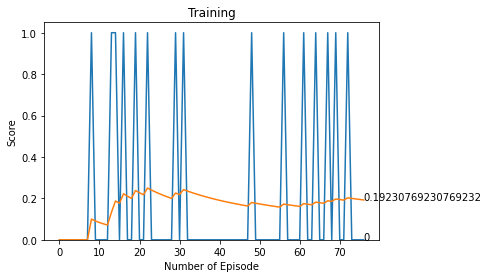

NameError: name 'quit' is not defined

In [11]:
plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
game = SnakeGameAI()

move = np.zeros(3).astype(np.int)
move = move.tolist()
#No.0
game.play_step(move)

episode = 1

# No.0 - play 1st frame
# No.1 - get action from CNN
# No.2 insert action into the game - get all things -> next state
# No.3 push into buffer
# No.4 current is next state

while True:
    model.train()
    state_i = state(game)
    # No.1 
    epsilon = 80 - episode
    if random.randint(0, 200) > epsilon:
        x = torch.tensor(state_i, dtype=torch.float)
        q_value = model(x.to(device))
        action  = torch.argmax(q_value).item()
        #state = state.squeeze(0)
    else:
        action = random.randrange(num_actions)

    move = action_array(action, num_actions)

    # No.2
    # perform move and get new state
    reward, done, score = game.play_step(move) 
    state_i_new = state(game)

    # train short memory
    loss = Loss(model, criterion, optimizer, gamma, state_i, state_i_new, move, reward, done)

    # No.3
    # push
    replay_buffer.push(state_i, state_i_new, move, reward, done)
    #state_i = state_i_new #4
    #episode_reward += reward

    if done:
        # train long memory, plot result
        game.reset()
        episode += 1

        if len(replay_buffer) > batch_size:
            states, next_states, actions, rewards, dones = replay_buffer.sample(batch_size)
        else:
            states, next_states, actions, rewards, dones = replay_buffer.sample(replay_buffer.__len__())

        loss = Loss(model, criterion, optimizer, gamma, states, next_states, actions, rewards, dones)
        #print(loss.item())
        if score > record:
            record = score
            save(model)

        print('Game', episode, 'Score', score, 'Record:', record)

        plt.ion()
        plot_scores.append(score)
        total_score += score
        mean_score = total_score / episode
        plot_mean_scores.append(mean_score)
        plot(plot_scores, plot_mean_scores)
        if (episode > total_eps):
            break

#print('Final Score', score)
pygame.display.quit() 
pygame.quit()

In [14]:
#replay_buffer.sample(replay_buffer.__len__())
replay_buffer.__len__()

0

In [20]:
print(q_value)

torch.argmax(q_value).item()

tensor([-0.2487, -0.0677,  0.1121], device='cuda:0', grad_fn=<AddBackward0>)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

# Demo

In [10]:
trained_model = DQN(11,256,3).to(device)
trained_model.load_state_dict(torch.load('agentP_2.pth'))

<All keys matched successfully>

<Figure size 432x288 with 0 Axes>

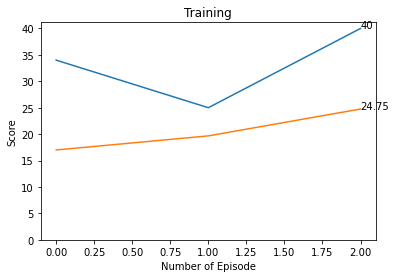

NameError: name 'quit' is not defined

In [11]:
plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
episode = 1
total_eps = 10

trained_model.eval()
game = SnakeGameAI()

move = np.zeros(3).astype(np.int)
move = move.tolist()
#No.0
game.play_step(move)

#episode = 1
while True:
    state_i = state(game)
    x = torch.tensor(state_i, dtype=torch.float)
    q_value = trained_model(x.to(device))
    action  = torch.argmax(q_value).item()
    
    move = action_array(action, 3)

    # No.2
    # perform move and get new state
    reward, done, score = game.play_step(move) 
    #state_i_new = state(game)
    
    if done:
        game.reset()
        episode += 1         
        if score > record:
            record = score

        print('Game', episode, 'Score', score, 'Record:', record)

        plt.ion()
        plot_scores.append(score)
        total_score += score
        mean_score = total_score / episode
        plot_mean_scores.append(mean_score)
        plot(plot_scores, plot_mean_scores)
        if (episode > total_eps):
            break

In [8]:
#print('Final Score', score)
pygame.display.quit() 
pygame.quit()